# Scan MERRA-2 atmospheric properties during one Year
------------------------------------------------------------------------------------

- author: Sylvie Dagoret-Campagne
- creation November 29 Novembre 2016
- update November 30 Novembre 2016
- updated January 6th : add November 2016 data
- update April 25th 2018


Link:

http://disc.sci.gsfc.nasa.gov/datareleases/merra_2_data_release

### purpose:

Scan One year of MERRA-2 predictions of the dataset inst1_2d_asm_Nx_M2I1NXASM over one month. 
Extract the relevant atmospheric variables.
Build the correcponding time series and dataset in pandas.
Plot the variables. Save the pandas dataset into a file.
Convert the pandas dataset into an astropy fits table and save into a fits file as well.



## 1) python libraries
---------------------------

In [1]:
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib as mpl
matplotlib.rc_file("templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

/pbs/throng/lsst/users/dagoret/External/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [2]:
import datetime

In [3]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [4]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [5]:
import os
import re
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

In [6]:
from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.table import Table

In [7]:
import h5py

In [8]:
import libGMAOMERRA2Data as merra2  # My own library

In [9]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

## 2)  Configuration
-------------------------

In [10]:
# SELECT OBSERVATORY
OBS_NAME='ctio'

In [11]:
# where are the HDF files
#HDFEOS_ZOO_DIR="/Volumes/DAGORETBACK/MERRA-2/inst1_2d_asm_Nx_M2I1NXASM/2016"
#HDFEOS_ZOO_DIR="/Volumes/LaCie2/DATA/MERRA-2/inst1_2d_asm_Nx_M2I1NXASM"
HDFEOS_ZOO_DIR="/sps/lsst/data/AtmosphericCalibration/MERRA-2/May-Jun-2017/subset_M2I1NXASM_V5.12.4_20180424_201411"

In [12]:
path=HDFEOS_ZOO_DIR

In [13]:
# The selected data field
DATA_NAME =  'inst1_2d_asm_Nx_M2I1NXASM'   # Select Ozone column Depth

In [14]:
pandas_filename='MERRA2_2017_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'.csv'

In [15]:
fits_filename='MERRA2_2017_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear' +'.fits'

In [16]:
figfile_ozone='GMAO_MERRA2_2017_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_ozone'+'.jpg'
figfile_pwv='GMAO_MERRA2_2017_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_pwv'+'.jpg'

In [17]:
# Select observatory
loc=merra2.observatory_location(OBS_NAME)

In [18]:
loc

(-70.815, -30.165277777777778, 2214.9999999993697)

### 2.2) Getting the list of the files
------------------------------

In [19]:
nc4_files = [f for f in os.listdir(path) if f.endswith('.nc4')]  

### 2.3) Select files of a given month

In [20]:
keysel_filename='^MERRA2_400.inst1_2d_asm_Nx.2017.*'

In [21]:
print 'Selection key' ,keysel_filename

Selection key ^MERRA2_400.inst1_2d_asm_Nx.2017.*


In [22]:
nc4_files2 = []
for file in nc4_files:
    if re.findall(keysel_filename,file):
        nc4_files2.append(file)

nc4_files2=np.array(nc4_files2)

### 2.4) Sort files by increasing time

In [23]:
nc4_files=np.sort(nc4_files2)

### 2.5) Build the full filename before reading

In [24]:
NBFILES=len(nc4_files)
full_nc4files=[]

for file in nc4_files:
    fname = os.path.join(path, file)
    full_nc4files.append(fname)  

## 3)  Extract data and write them into pandas dataset and time series
--------------------------------------------------------------------------------------

In [25]:
to3_timeseries=[] # example of time series for ozone
pwv_timeseries=[] # time series for precipitable water vapor
df_inst1_2d_asm_Nx=[] # dataset for all atmospheric quantities

for file in full_nc4files:
    
    #Retrieve 1D parameters longitude, latitude, time
    (m_lat,m_un_lat,m_nm_lat) = merra2.Get1DData(file,'lat') # latitude (array, unit, name)
    m_latitude = m_lat[:]
    (m_lon,m_un_lon,m_nm_lon) = merra2.Get1DData(file,'lon') # longitude(array, unit, name)
    m_longitude = m_lon[:]
    (m_tim,m_un_tim,m_nm_tim)= merra2.Get1DData(file,'time') # time (array, unit, name)
    m_time=m_tim[:]
       
    NbDataPerFile=m_time.shape[0] # number of data sample per file
    #start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)[ ]00:00:00$",m_un_tim) # extract start time
    start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)",m_un_tim) # extract start time
    
    #print 'start_time = ', start_time
    time_rng = pd.date_range(start_time[0], periods=NbDataPerFile, freq='H') # one data per hour
    
    print 'start_time = ', start_time
    
    m_X,m_Y=np.meshgrid(m_longitude,m_latitude) # build meash-grid in longitude and latitude
    (sel_long, sel_lat)=merra2.GetBinIndex(m_X,m_Y,loc[0],loc[1]) # get bin in longitude and latitude for the site  
    
    # Retrieve Ozone
    (m_to3_data,m_to3_unit,m_to3_longname)=merra2.GetGeoRefData(file,'TO3') # 3D array : time x longitude x latitude  
    to3=m_to3_data[:,sel_lat,sel_long]
    ts = pd.Series(to3, index=time_rng)
    to3_timeseries.append(ts)
    # Retrieve PWV
    (m_pwv_data,m_pwv_unit,m_pwv_longname)=merra2.GetGeoRefData(file,'TQV')
    pwv=m_pwv_data[:,sel_lat,sel_long]
    ts = pd.Series(pwv, index=time_rng)
    pwv_timeseries.append(ts)
    
    
    # Create the dataframe
    df = pd.DataFrame({'ozone': to3 , 'pwv' : pwv}, index=time_rng)
    df_inst1_2d_asm_Nx.append(df)  
    

start_time =  ['2017-04-30 00:00:00']
start_time =  ['2017-05-01 00:00:00']
start_time =  ['2017-05-02 00:00:00']
start_time =  ['2017-05-03 00:00:00']
start_time =  ['2017-05-04 00:00:00']
start_time =  ['2017-05-05 00:00:00']
start_time =  ['2017-05-06 00:00:00']
start_time =  ['2017-05-07 00:00:00']
start_time =  ['2017-05-08 00:00:00']
start_time =  ['2017-05-09 00:00:00']
start_time =  ['2017-05-10 00:00:00']
start_time =  ['2017-05-11 00:00:00']
start_time =  ['2017-05-12 00:00:00']
start_time =  ['2017-05-13 00:00:00']
start_time =  ['2017-05-14 00:00:00']
start_time =  ['2017-05-15 00:00:00']
start_time =  ['2017-05-16 00:00:00']
start_time =  ['2017-05-17 00:00:00']
start_time =  ['2017-05-18 00:00:00']
start_time =  ['2017-05-19 00:00:00']
start_time =  ['2017-05-20 00:00:00']
start_time =  ['2017-05-21 00:00:00']
start_time =  ['2017-05-22 00:00:00']
start_time =  ['2017-05-23 00:00:00']
start_time =  ['2017-05-24 00:00:00']
start_time =  ['2017-05-25 00:00:00']
start_time =

## 4) Plot the time dependence of time series and dataset

####  Fill information on years and months from the filenames

In [26]:
result = pd.concat(to3_timeseries)

Text(0,0.5,u'ozone')

/pbs/throng/lsst/users/dagoret/External/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


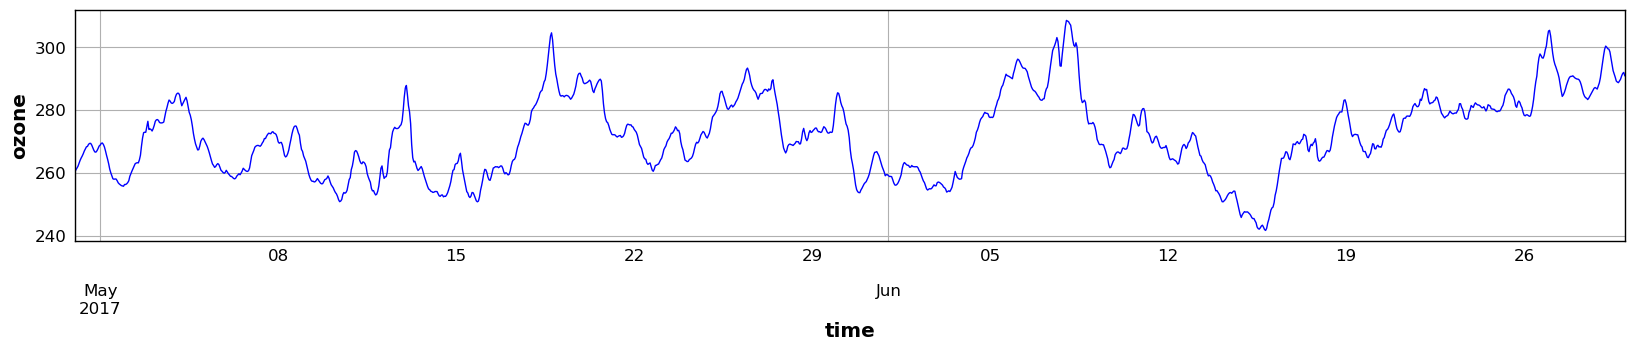

In [27]:
plt.figure(figsize=(20,3))
result.plot(grid=True,color='blue')
plt.xlabel('time')
plt.ylabel('ozone')

In [28]:
result = pd.concat(pwv_timeseries)

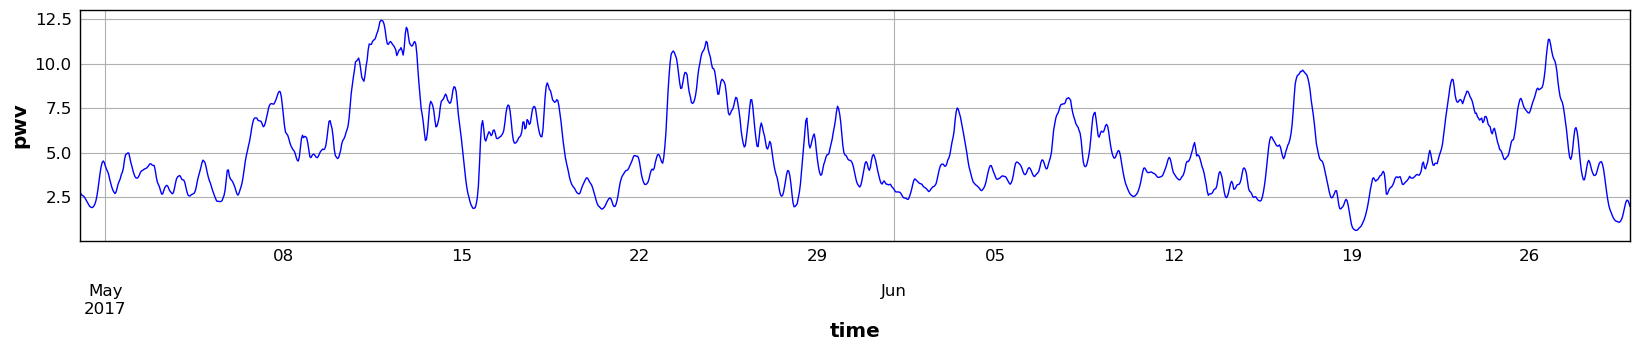

In [29]:
plt.figure(figsize=(20,3))
result.plot(grid=True,color='blue')
plt.xlabel('time')
plt.ylabel('pwv')
plt.grid(True)

In [30]:
df_inst1_2d_asm_Nx_tot=pd.concat(df_inst1_2d_asm_Nx)

In [31]:
df_inst1_2d_asm_Nx_tot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1464 entries, 2017-04-30 00:00:00 to 2017-06-29 23:00:00
Data columns (total 2 columns):
ozone    1464 non-null float32
pwv      1464 non-null float32
dtypes: float32(2)
memory usage: 22.9 KB


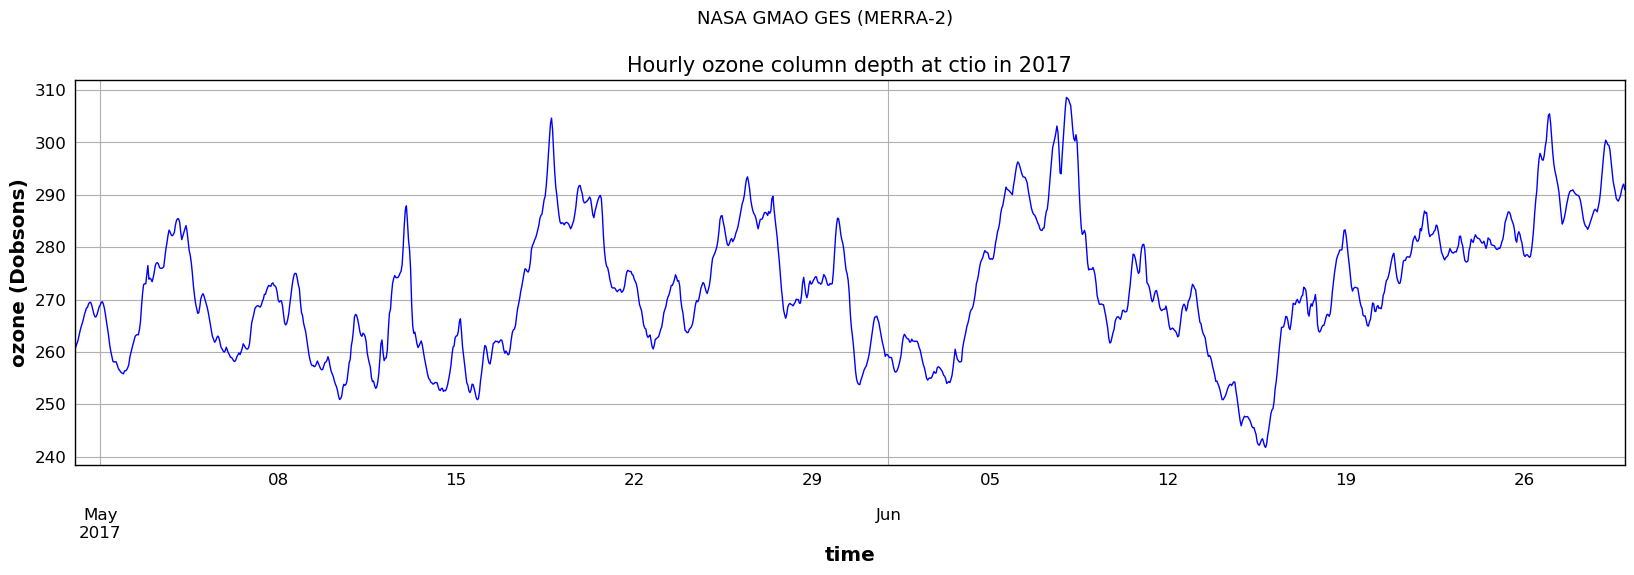

In [32]:
plt.figure(figsize=(20,5))
df_inst1_2d_asm_Nx_tot['ozone'].plot(color='blue')
plt.xlabel('time')
plt.ylabel('ozone (Dobsons)')
title= "Hourly ozone column depth at {} in 2017".format(OBS_NAME)
plt.title(title,fontsize=15)
plt.suptitle('NASA GMAO GES (MERRA-2)', y=1.02, fontsize=13)
plt.grid(True)
plt.savefig(figfile_ozone)

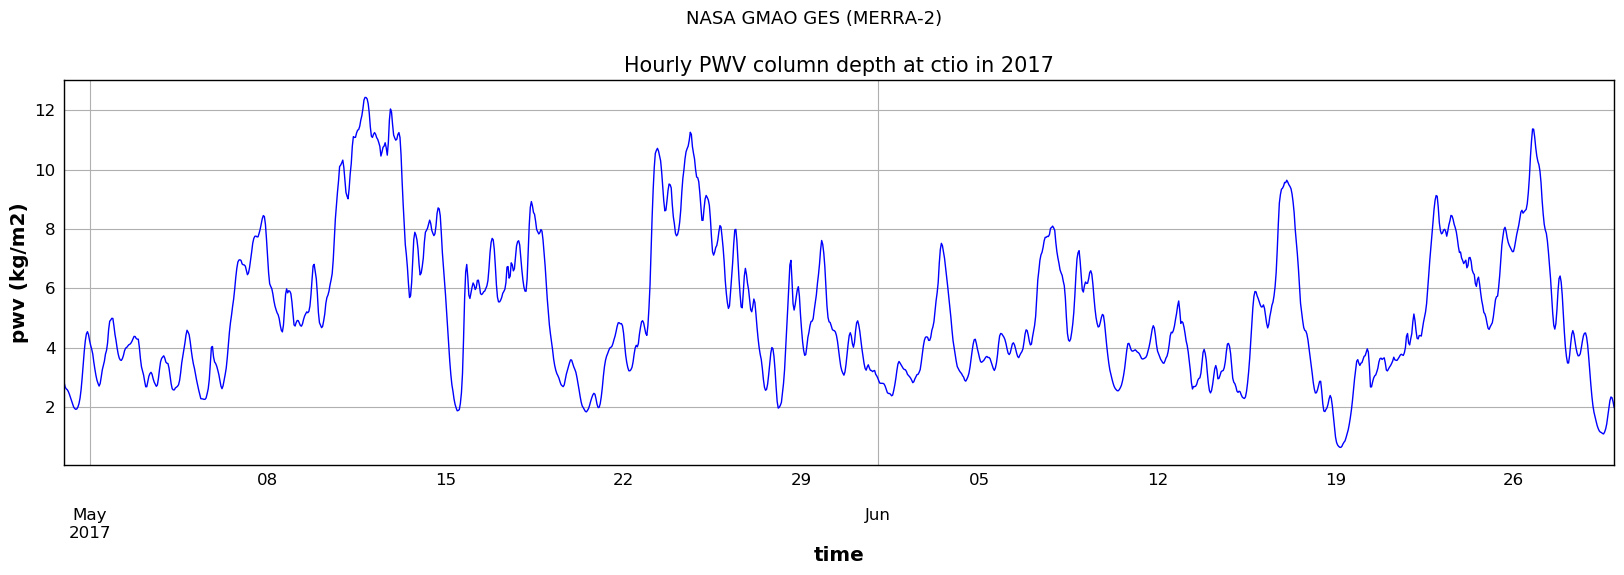

In [33]:
plt.figure(figsize=(20,5))
df_inst1_2d_asm_Nx_tot['pwv'].plot(grid=True,color='blue')
plt.xlabel('time')
plt.ylabel('pwv (kg/m2)')
title= "Hourly PWV column depth at {} in 2017".format(OBS_NAME)
plt.title(title,fontsize=15)
plt.suptitle('NASA GMAO GES (MERRA-2)', y=1.02, fontsize=13)
plt.grid(True)
plt.savefig(figfile_pwv)

In [34]:
df_inst1_2d_asm_Nx_tot.index.name='time'
df_inst1_2d_asm_Nx_tot.describe()

,ozone,pwv
count,1464.000000,1464.000000
mean,271.979034,5.205767
std,12.735446,2.419247
min,241.780853,0.637064
25%,262.272858,3.395078
50%,270.982361,4.580555
75%,281.492615,6.782194
max,308.591034,12.429529


## 5)  Save dataset  in file pandas (csv)
----------------------------------------

In [35]:
dataset=df_inst1_2d_asm_Nx_tot

In [36]:
dataset.index.name='time'

In [37]:
dataset.describe()

,ozone,pwv
count,1464.000000,1464.000000
mean,271.979034,5.205767
std,12.735446,2.419247
min,241.780853,0.637064
25%,262.272858,3.395078
50%,270.982361,4.580555
75%,281.492615,6.782194
max,308.591034,12.429529


In [38]:
dataset.head()

,ozone,pwv
time,,
2017-04-30 00:00:00,260.352051,2.822547
2017-04-30 01:00:00,261.006653,2.668410
2017-04-30 02:00:00,261.566254,2.609197
2017-04-30 03:00:00,262.164581,2.579537
2017-04-30 04:00:00,263.143188,2.517037


In [39]:
dataset.to_csv(pandas_filename)

In [40]:
saved_dataset=pd.read_csv(pandas_filename)

In [41]:
saved_dataset.head()

,time,ozone,pwv
0,2017-04-30 00:00:00,260.352051,2.822547
1,2017-04-30 01:00:00,261.006653,2.668410
2,2017-04-30 02:00:00,261.566254,2.609197
3,2017-04-30 03:00:00,262.164581,2.579537
4,2017-04-30 04:00:00,263.143188,2.517037


## 6) Convert dataset into a table and then save in a fits file
--------------------------------------------------------------------------

In [42]:
table = Table.from_pandas(saved_dataset)

In [43]:
table

time,ozone,pwv
str19,float64,float64
2017-04-30 00:00:00,260.352050781,2.8225467205
2017-04-30 01:00:00,261.006652832,2.66840982437
2017-04-30 02:00:00,261.566253662,2.6091966629
2017-04-30 03:00:00,262.164581299,2.57953715324
2017-04-30 04:00:00,263.143188477,2.51703667641
2017-04-30 05:00:00,264.033966064,2.42353320122
2017-04-30 06:00:00,264.78326416,2.31749463081
2017-04-30 07:00:00,265.426025391,2.21690416336
2017-04-30 08:00:00,266.163208008,2.11148262024


In [44]:
table.write(fits_filename,format='fits',overwrite=True)